# **Intro linear latent space arithmetic PCA**
In this notebook I use a PCA in order to predict the gene expression changes induced by a perturbation.
Here, we want to know the cell-type specific perturbation effect.
We use unperturbed single-cell and pert+unpert bulk in order to infer the cell-type specific expressiom change.
To do this, we use latent space arithmetic, where the latent space is the PCA space. 





# **Imports**

In [64]:
# general imports
import warnings
import numpy as np
import scanpy as sc
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [65]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/home/natalie/projects/checkouts/buddi/buddi/plotting/validation_plotting.py'>

In [66]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_sciplex_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/PCA_sciplex/"

cibersort_genes_path = (f"{os.getcwd()}/../../data/single_cell_data/cibersort_sciplex/" +
                        "CIBERSORTx_Job67_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job67_test_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-sciplex"
curr_treatment = "K562"
res_id = f"{curr_treatment}-sciplex"


RETRAIN_MODELS = False

# Set-up experimental variables

In [67]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 3

# number of patients/domains/samples expected
n_tot_samples = 1 # 

# number of drugs 
# one-hot encoded
n_drugs = 6

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [68]:


# read in all the data

stim_order = ['CTRL', "STIM"]
train_order = ['Train', "Test"]
cell_order = [curr_treatment]
drug_order = ["Tanespimycin (17-AAG)", "Fedratinib (SAR302503, TG101348)",
              "Trametinib (GSK1120212)", "Triamcinolone Acetonide", "Trichostatin A (TSA)"]

X_full = None
Y_full = None
meta_df = None
for curr_train in train_order:
    for curr_stim in stim_order:
        for curr_drug in drug_order:
            for curr_cell_type in cell_order:

                curr_samp = f"{curr_drug}_{curr_cell_type}"

                print(curr_samp)

                pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, curr_stim, curr_train, exp_id)
                pseudobulks_df.columns = gene_df

                if X_full is None:
                    X_full, Y_full, meta_df = pseudobulks_df, prop_df, metadata_df
                else:
                    X_full = pd.concat([X_full, pseudobulks_df])
                    Y_full = pd.concat([Y_full, prop_df])
                    meta_df = pd.concat([meta_df, metadata_df])

X_full.columns = gene_df

# the perturbation is applied in a cell type specific manner
meta_df['perturbation'] = meta_df['perturbation'] + '_' + meta_df['cell_type_perturbed']
meta_df['perturbation'].iloc[np.where(meta_df.stim == "CTRL")] = "control"
meta_df["sample_id"] = "samp1"

# for the bulks, only keep the samples with
# the perturbed cell type as the majority
# or less than 20%

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max


Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562
Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562
Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562
Tanespimycin (17-AAG)_K562
Fedratinib (SAR302503, TG101348)_K562
Trametinib (GSK1120212)_K562
Triamcinolone Acetonide_K562
Trichostatin A (TSA)_K562


In [69]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.perturbation)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim != "CTRL")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)

# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()


## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] 
gene_df = gene_df.iloc[idx_top]



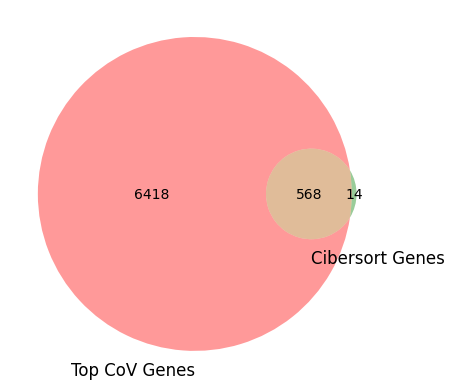

In [70]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [71]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [72]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = scaler.transform(X_full)

# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
#idx_bulk_train = np.random.choice(idx_bulk_train, 2000, replace=True)

X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
#idx_sc_train = np.random.choice(idx_sc_train, 5000, replace=True)

X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.020s...
[t-SNE] Computed neighbors for 15000 samples in 4.009s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

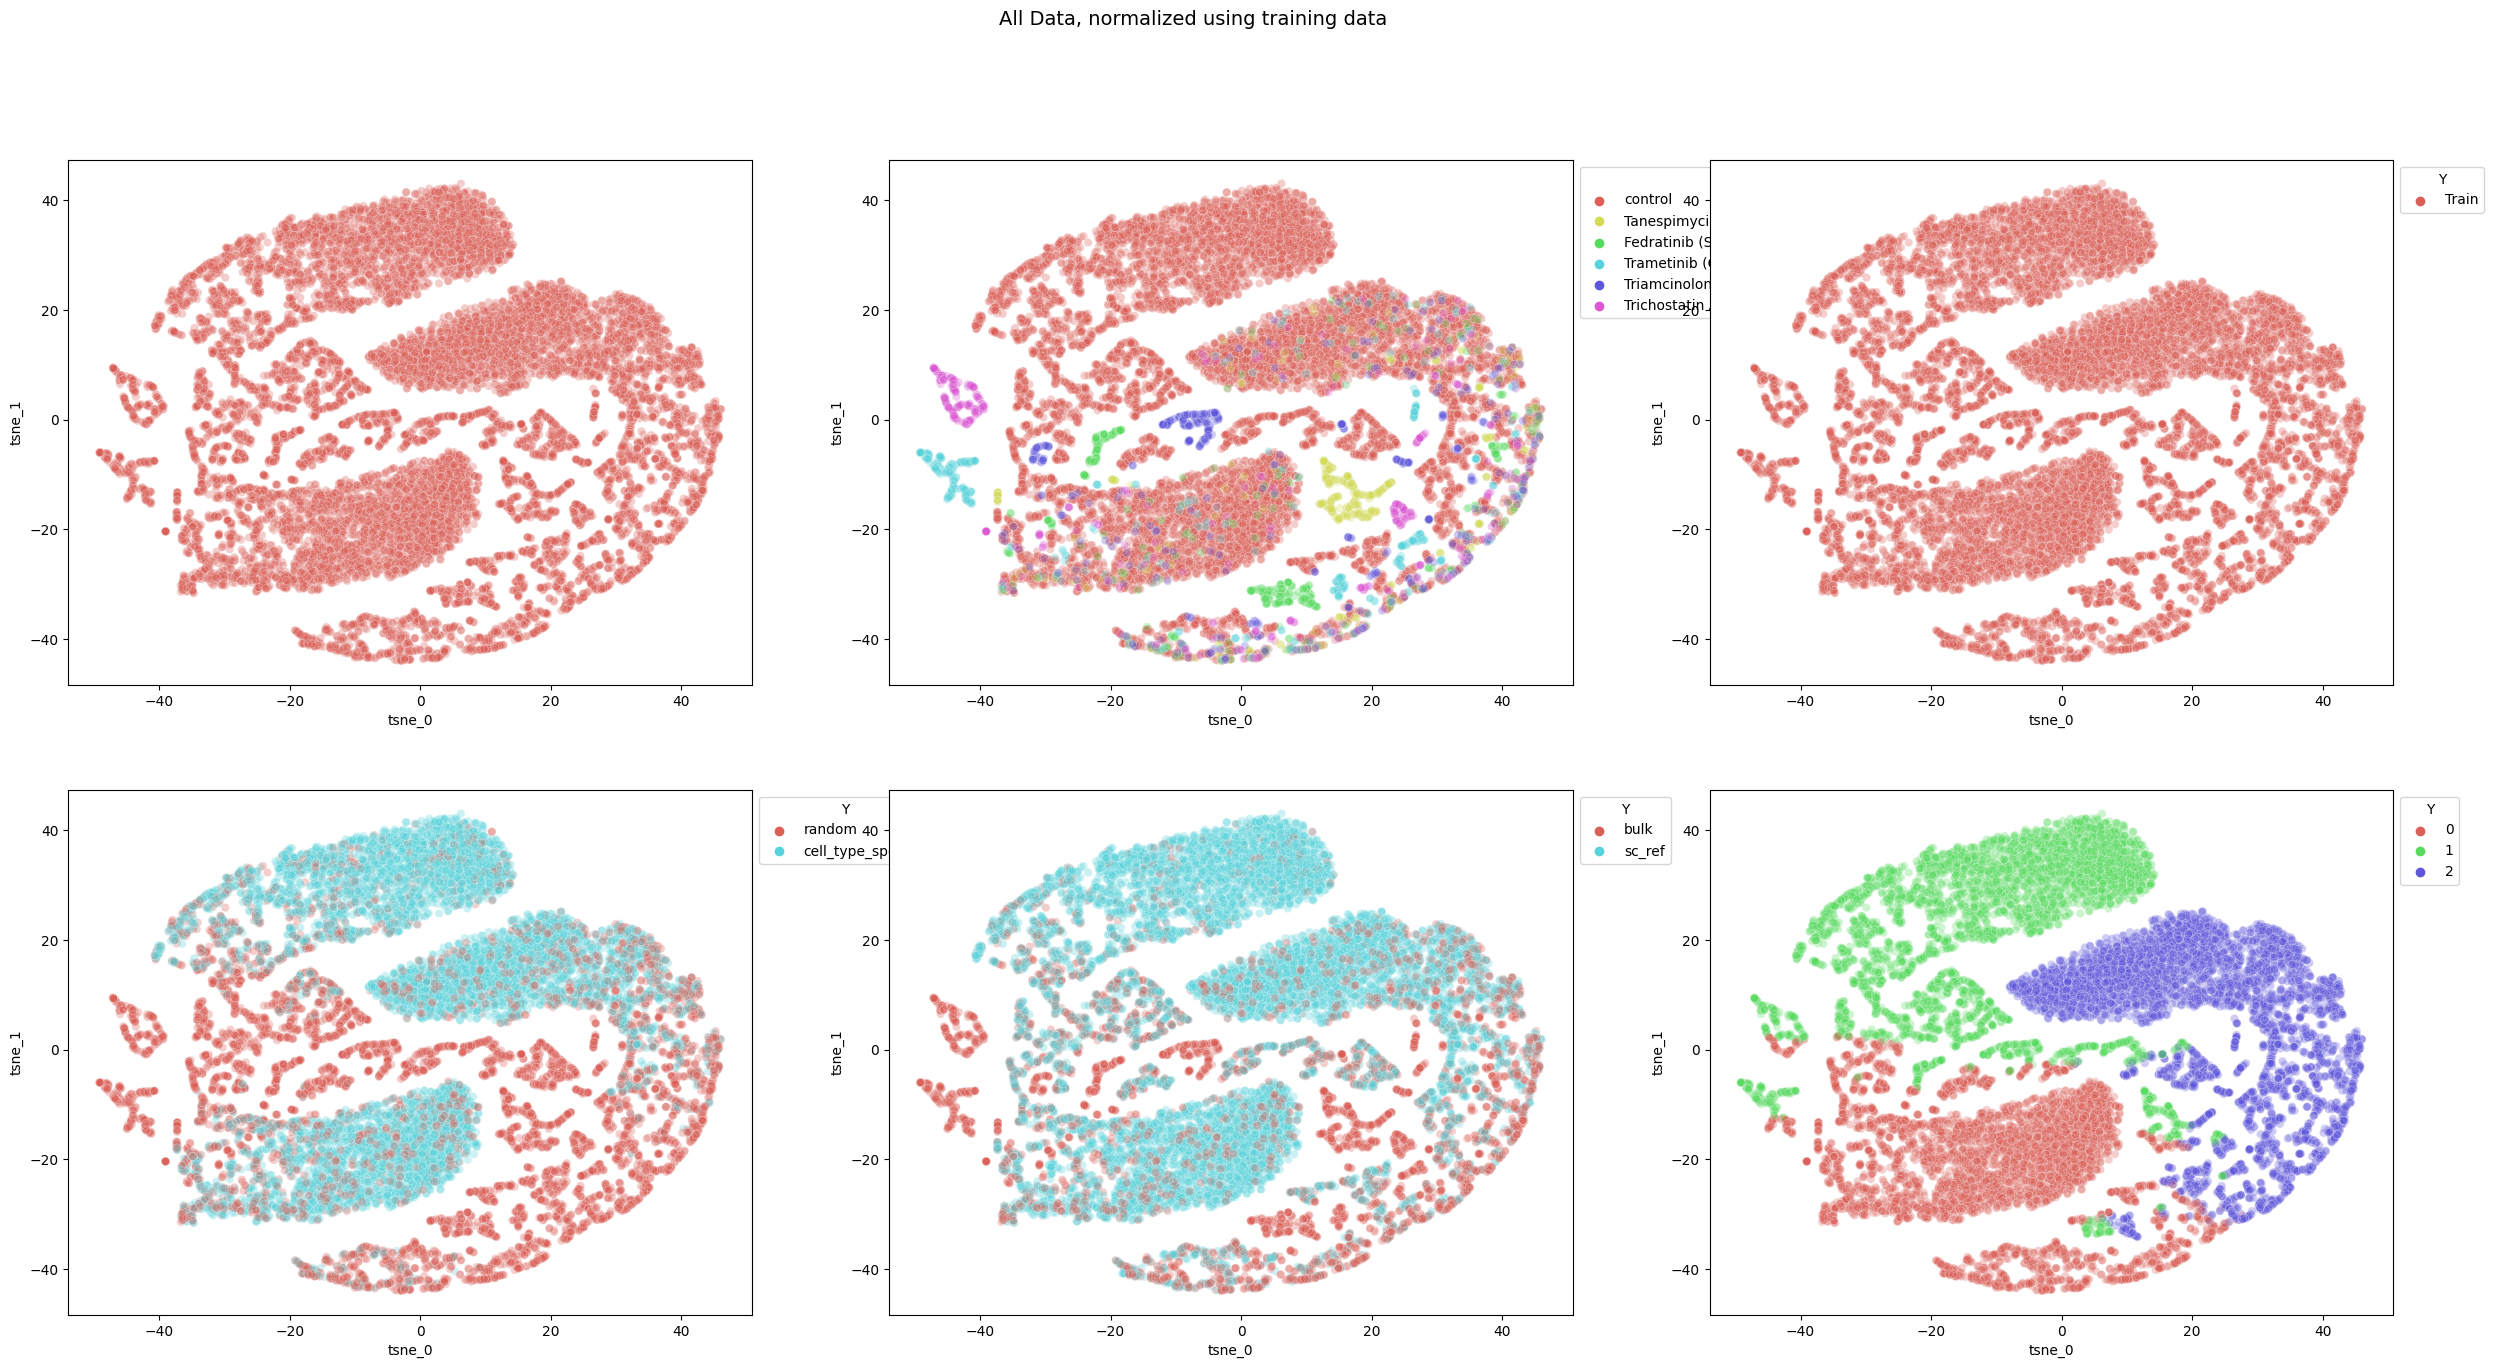

In [73]:
## plot samples
idx_tmp = np.union1d(idx_sc_train, idx_bulk_train)


plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].perturbation.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **PCA Model Definition**

In [74]:
len(np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type != "bulk"))[0] )

10000

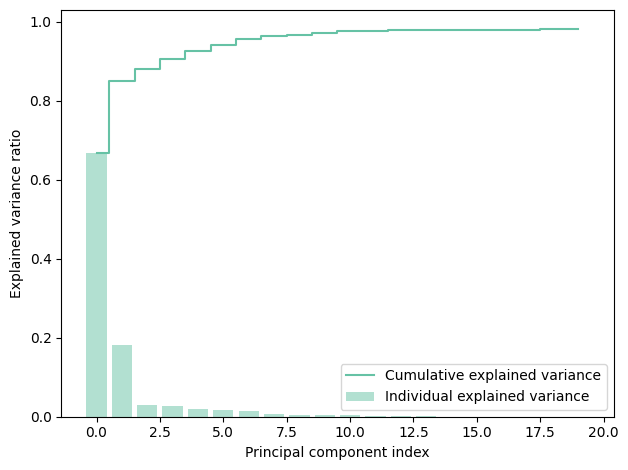

In [75]:
### get training data

idx_bulk_train = np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type == "bulk"))[0] 
X_temp = X_full[idx_bulk_train]

fit = PCA(n_components=20)
pca_results = fit.fit_transform(X_temp)

exp_var_pca = fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

## plot variance explained
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [76]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full

recon_idx = np.where(meta_df.isTraining == "Train")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)


Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(10000, 2)
(10000, 2)


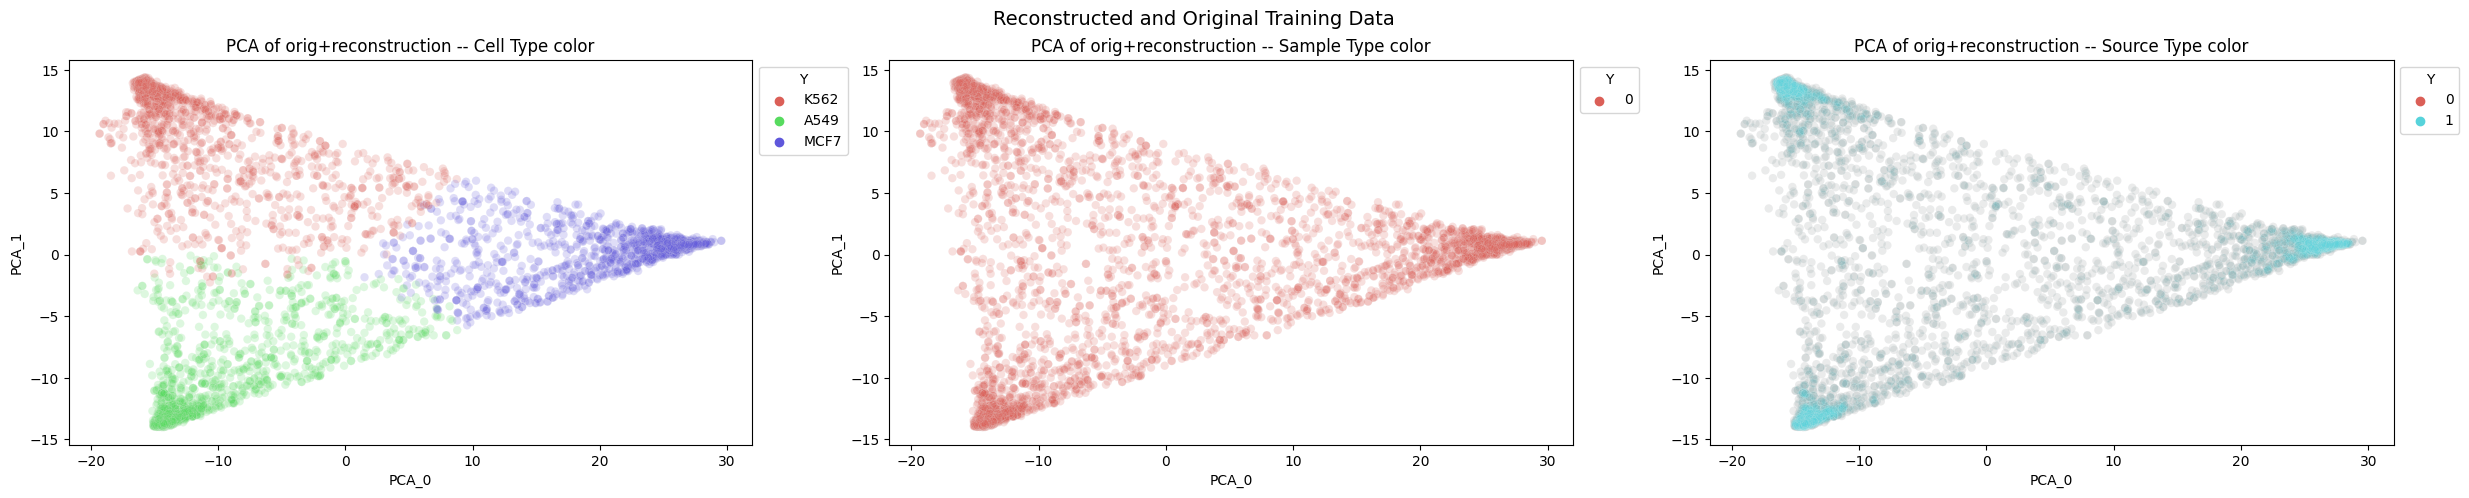

In [77]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCA of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

In [78]:
meta_df

sample_id  stim isTraining      cell_prop_type samp_type  \
0        samp1  CTRL      Train              random      bulk   
1        samp1  CTRL      Train              random      bulk   
2        samp1  CTRL      Train              random      bulk   
3        samp1  CTRL      Train              random      bulk   
4        samp1  CTRL      Train              random      bulk   
...        ...   ...        ...                 ...       ...   
2495     samp1  STIM       Test  cell_type_specific    sc_ref   
2496     samp1  STIM       Test  cell_type_specific    sc_ref   
2497     samp1  STIM       Test  cell_type_specific    sc_ref   
2498     samp1  STIM       Test  cell_type_specific    sc_ref   
2499     samp1  STIM       Test  cell_type_specific    sc_ref   

                   perturbation cell_type_perturbed Y_max  
0                       control                K562  K562  
1                       control                K562  K562  
2                       control                K562  K562  
3                       control                K562  A549  
4                       control                K562  A549  
...                         ...                 ...   ...  
2495  Trichostatin A (TSA)_K562                K562  MCF7  
2496  Trichostatin A (TSA)_K562                K562  MCF7  
2497  Trichostatin A (TSA)_K562                K562  MCF7  
2498  Trichostatin A (TSA)_K562                K562  MCF7  
2499  Trichostatin A (TSA)_K562                K562  MCF7  

[40000 rows x 8 columns]

In [79]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full
bulk_temp = bulk_full

recon_idx = np.where(meta_df.isTraining == "Test")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(10000, 2)
(10000, 2)


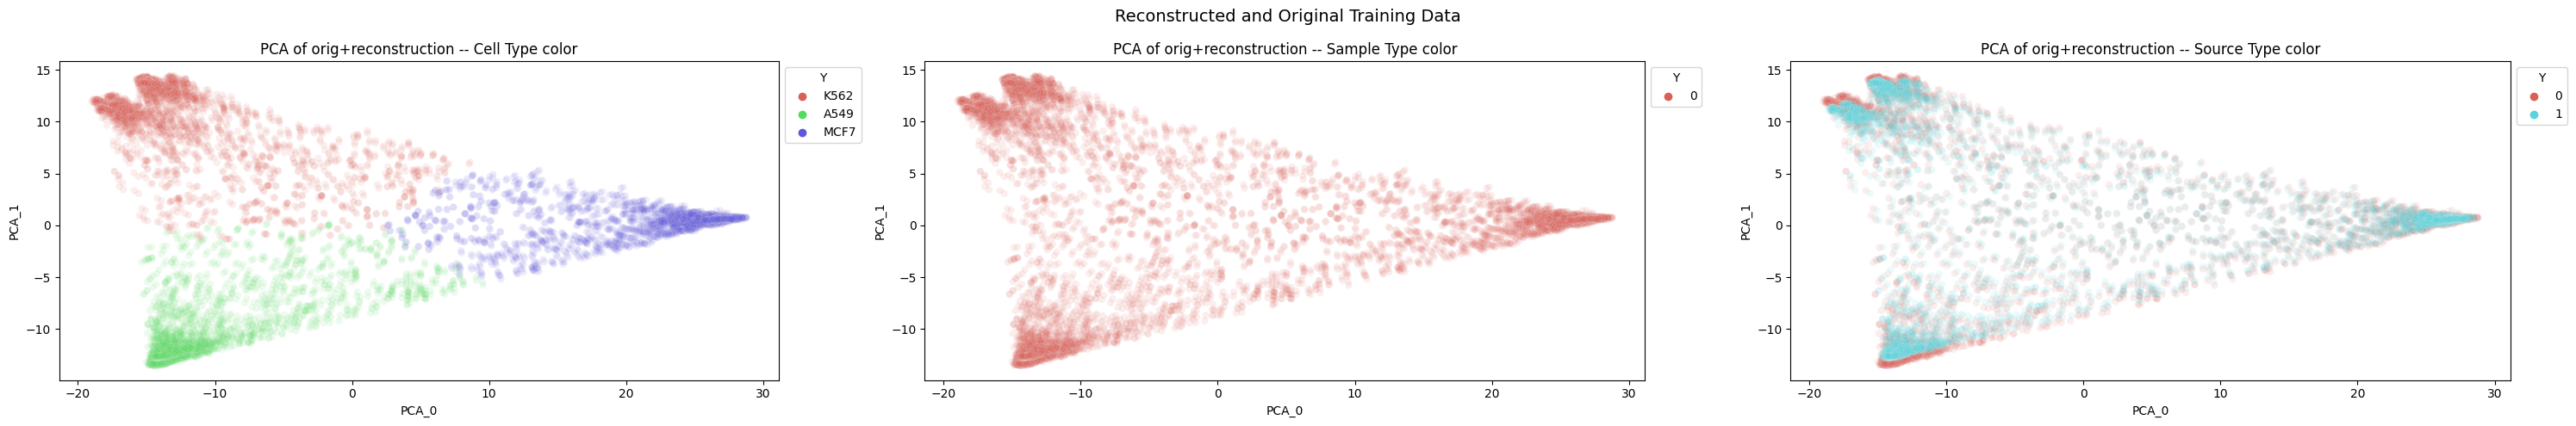

In [80]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCA of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()
fig.tight_layout()


(5000, 2)
(5000, 2)


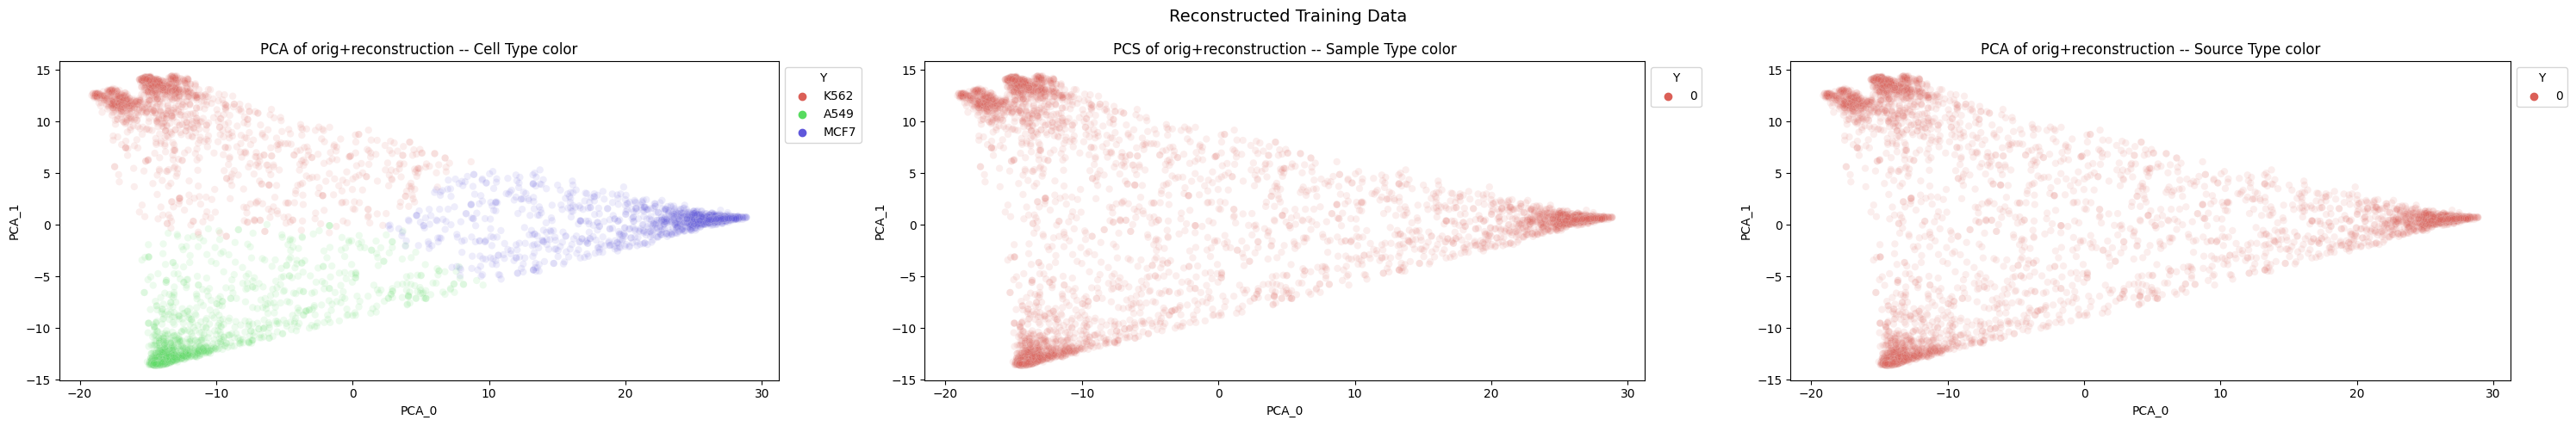

In [81]:

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_num, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=[0]*len(perturb_temp), ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()
fig.tight_layout()


(5000, 2)
(5000, 2)


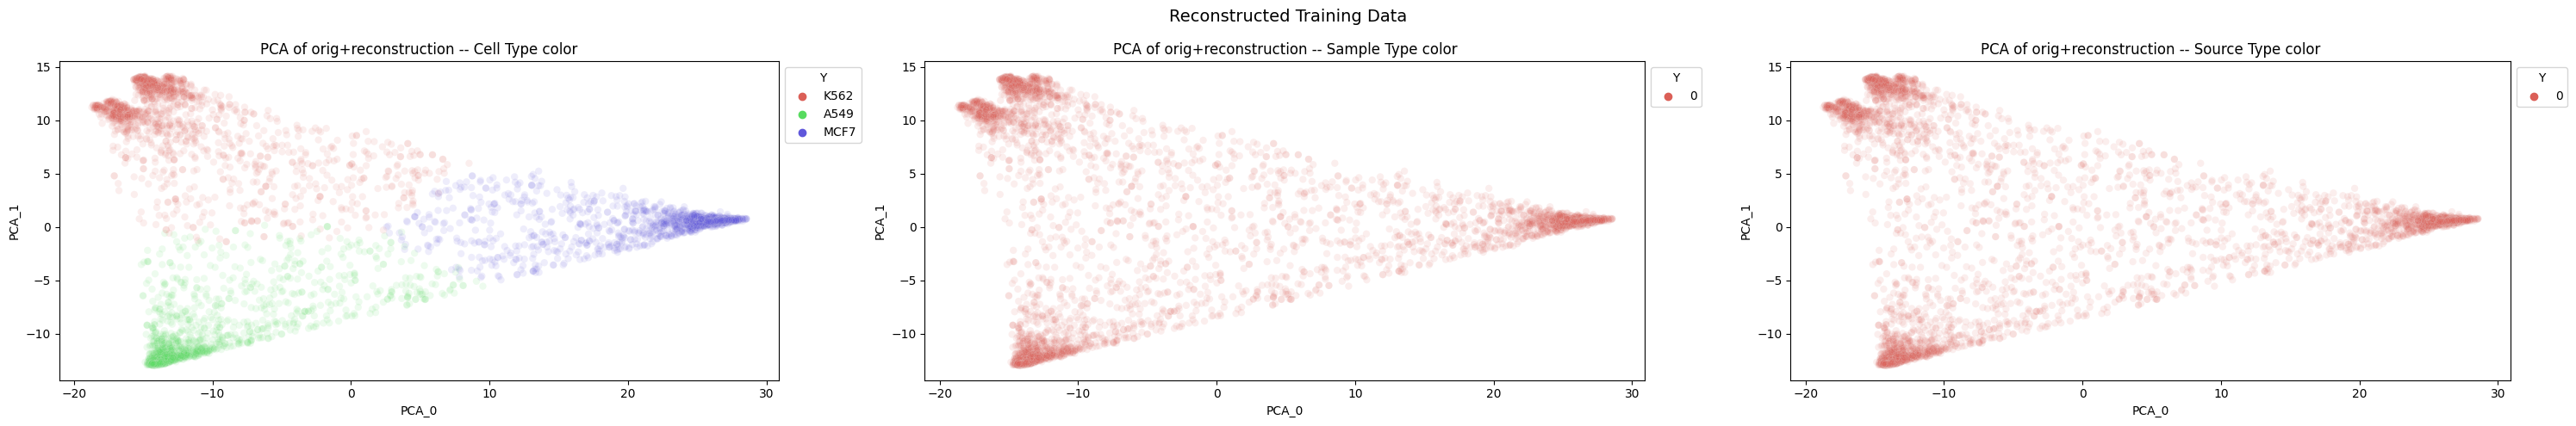

In [82]:

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_num, ax=axs[1], title="PCA of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=[0]*len(perturb_temp), ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()
fig.tight_layout()


## Do latent space projectsions

### drug perturbation

for each sample, calculate a sample projection vector and a perturbation vector. Using these two vectors we will simulate the cell- and sample-specific perturbation.

In [83]:

def calc_PCA_perturbation(X_full, meta_df, scaler, fit, sample_interest, curr_cell_type_perturbed, curr_drug):

    # get the single cell reference with no perturbation
    idx_sc_ref = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Train")
    idx_sc_ref = np.logical_and(idx_sc_ref, meta_df.samp_type == "sc_ref")
    idx_sc_ref = np.logical_and(idx_sc_ref, meta_df.cell_prop_type == "cell_type_specific")
    idx_sc_ref = np.where(idx_sc_ref)[0]
    sc_ref_meta_df = meta_df.iloc[idx_sc_ref]

    X_sc_ref = np.copy(X_full)
    X_sc_ref = X_sc_ref[idx_sc_ref,]

    # get the case+control for the drg and cell type of interest
    ct_perturbed_idx = np.where(meta_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]
    drug_idx = np.where((meta_df["perturbation"] == curr_drug) | (meta_df["perturbation"] == "control"))[0]
    curr_idx = np.intersect1d(drug_idx, ct_perturbed_idx)

    ## get the transofrmation vectors
    proj_vec = vp.get_pert_transform_vec_PCA(X_full[curr_idx], meta_df.iloc[curr_idx], sample_interest, fit)


    # now get the refernce sample that we will use to do all projectsions
    single_decoded_0_0 = fit.transform(X_sc_ref)
    single_decoded_0_1 = np.copy(single_decoded_0_0)

    # do the projections
    decoded_0_0 = None
    decoded_0_1 = None
    final_meta_df = None
    curr_decoded_0_0 = single_decoded_0_0.copy()
    curr_decoded_0_1 = single_decoded_0_1.copy()
    curr_meta_df = sc_ref_meta_df.copy()
    for curr_idx in range(X_sc_ref.shape[0]):

        curr_decoded_0_1[curr_idx] = curr_decoded_0_0[curr_idx] + proj_vec
        curr_meta_df.iloc[curr_idx].sample_id = sample_interest
        curr_meta_df.iloc[curr_idx].isTraining = "Test"

    ### append new df
    if final_meta_df is None:
        decoded_0_0 = curr_decoded_0_0
        decoded_0_1 = curr_decoded_0_1
        final_meta_df = curr_meta_df
    else:
        decoded_0_0 = np.append(decoded_0_0, curr_decoded_0_0, axis=0)
        decoded_0_1 = np.append(decoded_0_1, curr_decoded_0_1, axis=0)
        final_meta_df = final_meta_df.append(curr_meta_df)


    decoded_0_1 = fit.inverse_transform(decoded_0_1)
    decoded_0_1 = scaler.inverse_transform(decoded_0_1)

    decoded_0_0 = fit.inverse_transform(decoded_0_0)
    decoded_0_0 = scaler.inverse_transform(decoded_0_0)

    return (final_meta_df, decoded_0_0, decoded_0_1)


In [84]:
from scipy.stats import ttest_ind
import math

def get_nonperturbed_log2fc(curr_cell_type_perturbed,
                            meta_df, X_full, scaler, show_fig=False):
    
    curr_samp = "samp1"

    ct_perturbed_idx = np.where(meta_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]

    all_perts = meta_df.iloc[ct_perturbed_idx].perturbation.unique()
    all_perts = np.setdiff1d(all_perts, "control")

    all_Ymax = np.setdiff1d(meta_df.Y_max.unique(), curr_cell_type_perturbed)

    curr_cell_type = curr_cell_type_perturbed

    res_df = None

    for curr_drug in all_perts:
        for curr_Ymax in all_Ymax:

            print(f"{curr_drug} {curr_Ymax} {curr_cell_type_perturbed}")

            drug_idx = np.where((meta_df["perturbation"] == curr_drug) | (meta_df["perturbation"] == "control"))[0]

            curr_idx = np.intersect1d(drug_idx, ct_perturbed_idx)


            sc_proj_meta_df, decoded_0_0, decoded_0_1 = calc_PCA_perturbation(X_full, meta_df, scaler, 
                                                                              fit, curr_samp, 
                                                                              curr_cell_type_perturbed, 
                                                                              curr_drug)
            decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
            decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)


            # make QC plots
            # make duplicated
            X_dup = np.vstack([decoded_0_0, decoded_0_1])
            Y_dup = np.append(sc_proj_meta_df.Y_max, sc_proj_meta_df.Y_max)
            label_dup = np.append(sc_proj_meta_df.sample_id, sc_proj_meta_df.sample_id)

            n_row_temp = sc_proj_meta_df.shape[0]
            perturb_dup = np.asarray(np.append([0]*n_row_temp, [1]*n_row_temp))
            source_dup = np.append(sc_proj_meta_df.samp_type, sc_proj_meta_df.samp_type)

            fig, axs = plt.subplots(1, 2, figsize=(10,5))
            plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
            vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0])
            vp.plot_pca(plot_df, color_vec=perturb_dup, ax=axs[1])
            fig.suptitle(f"{curr_drug} {curr_cell_type_perturbed} Comparing the simulation of CTRL vs STIM on training data", fontsize=14)
            plt.tight_layout()

            if show_fig:
                fig.show()


            real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full[curr_idx], decoded_0_0, 
                                                                                            decoded_0_1, scaler, curr_samp, 
                                                                                            "cell_type_specific", 
                                                                                            meta_df.iloc[curr_idx], sc_proj_meta_df,
                                                                                            curr_Ymax)

            real_p_val = []
            subsamp_idx = np.random.choice(real_stim.shape[0], 9)
            for col_idx in range(real_stim.shape[1]):
                _, p_value = ttest_ind(real_stim[subsamp_idx,col_idx], real_ctrl[subsamp_idx,col_idx])
                real_p_val.append(p_value)

            real_p_val = [1 if math.isnan(x) else x for x in real_p_val]

            proj_p_val = []
            subsamp_idx = np.random.choice(proj_stim.shape[0], 9)
            for col_idx in range(proj_stim.shape[1]):
                _, p_value = ttest_ind(proj_stim[subsamp_idx,col_idx], proj_ctrl[subsamp_idx,col_idx])
                proj_p_val.append(p_value)

            proj_p_val = [1 if math.isnan(x) else x for x in proj_p_val]

            real_stim_med = np.median(real_stim, axis=0)
            proj_stim_med = np.median(proj_stim, axis=0)

            real_ctrl_med = np.median(real_ctrl, axis=0)
            proj_ctrl_med = np.median(proj_ctrl, axis=0)


            real_ctrl_med_1 = np.median(real_ctrl, axis=0)+1
            real_stim_med_1 = np.median(real_stim, axis=0)+1
            real_log2FC = np.log2(real_stim_med_1/real_ctrl_med_1)

            proj_ctrl_med_1 = np.median(proj_ctrl, axis=0)+1
            proj_stim_med_1 = np.median(proj_stim, axis=0)+1
            proj_log2FC = np.log2(proj_stim_med_1/proj_ctrl_med_1)

            print(len(proj_log2FC.tolist() +  real_log2FC.tolist()))
            print(len(curr_idx))

            

            num_sig_real = [True if x < 0.05/len(real_p_val) else False for x in real_p_val]
            num_sig_proj = [True if x < 0.05/len(proj_p_val) else False for x in proj_p_val]

            plot_df = pd.DataFrame({"log2FC": [np.sum(num_sig_proj), np.sum(num_sig_real)],
                                    "source":["proj", "real"],
                                    "Y_max":[curr_Ymax, curr_Ymax],
                                    "perturbation":[curr_drug, curr_drug]})
            
            if res_df is None:
                res_df = plot_df
            else:
                res_df = pd.concat([res_df, plot_df])

    return res_df

Fedratinib (SAR302503, TG101348)_K562 A549 K562


(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Fedratinib (SAR302503, TG101348)_K562 MCF7 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Tanespimycin (17-AAG)_K562 A549 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Tanespimycin (17-AAG)_K562 MCF7 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Trametinib (GSK1120212)_K562 A549 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Trametinib (GSK1120212)_K562 MCF7 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Triamcinolone Acetonide_K562 A549 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Triamcinolone Acetonide_K562 MCF7 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Trichostatin A (TSA)_K562 A549 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000
Trichostatin A (TSA)_K562 MCF7 K562
(15000, 2)
(15000, 2)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


14000
28000


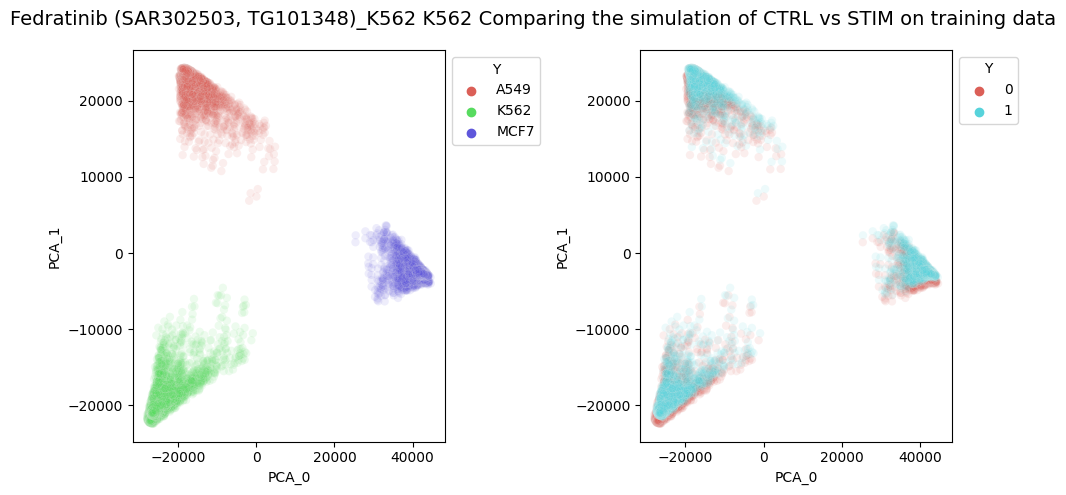

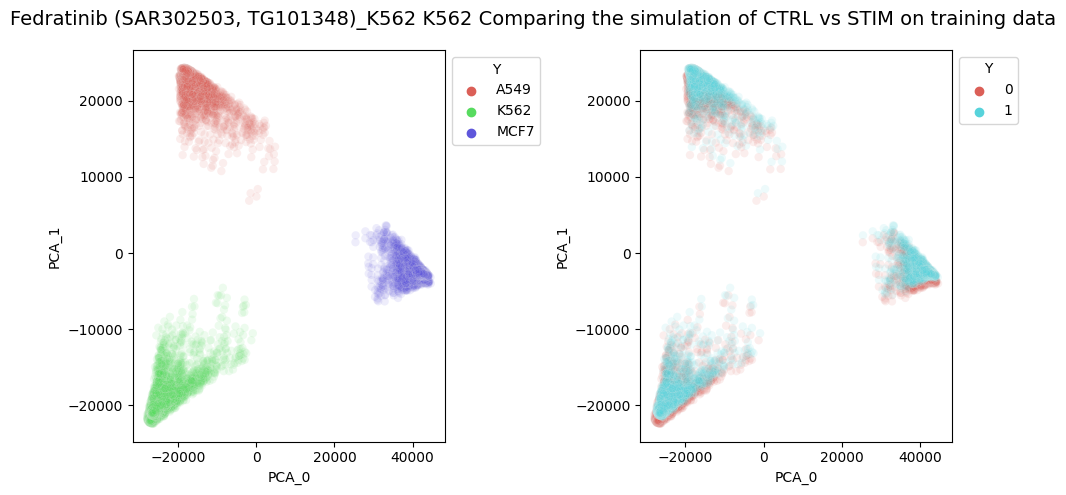

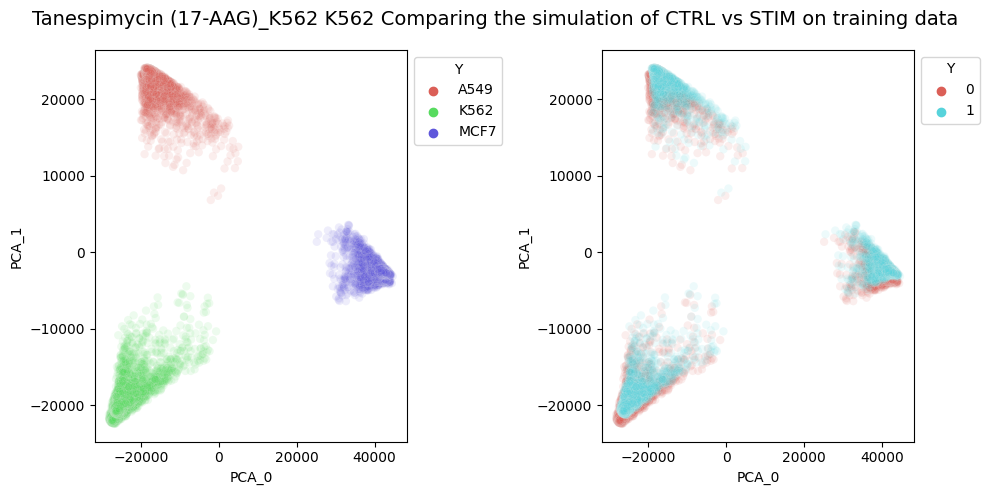

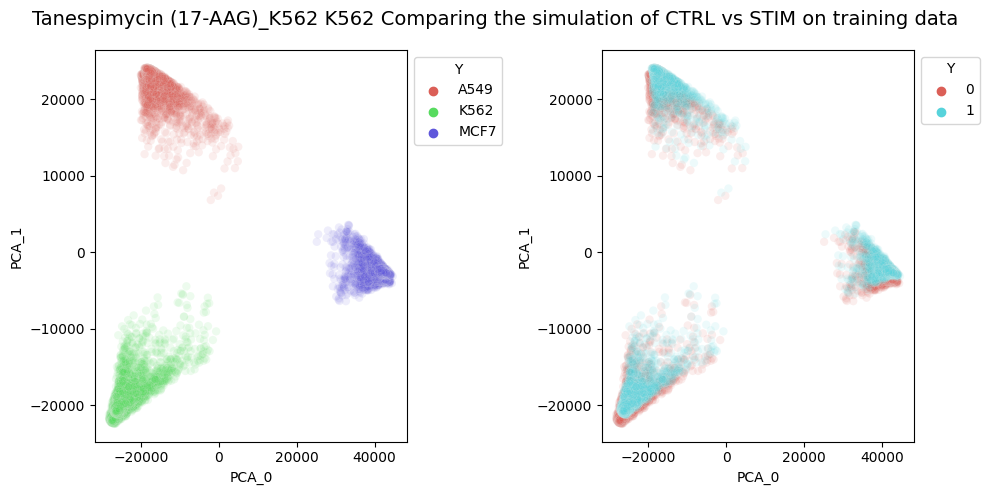

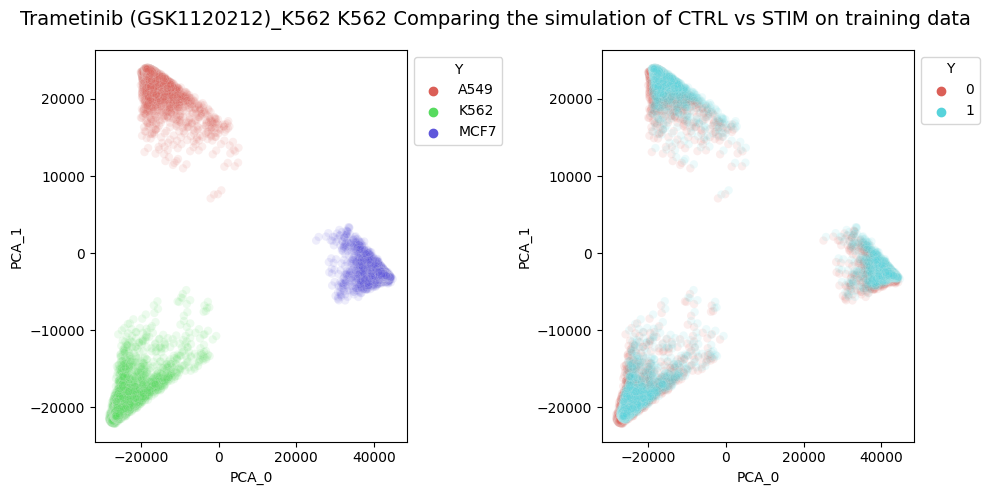

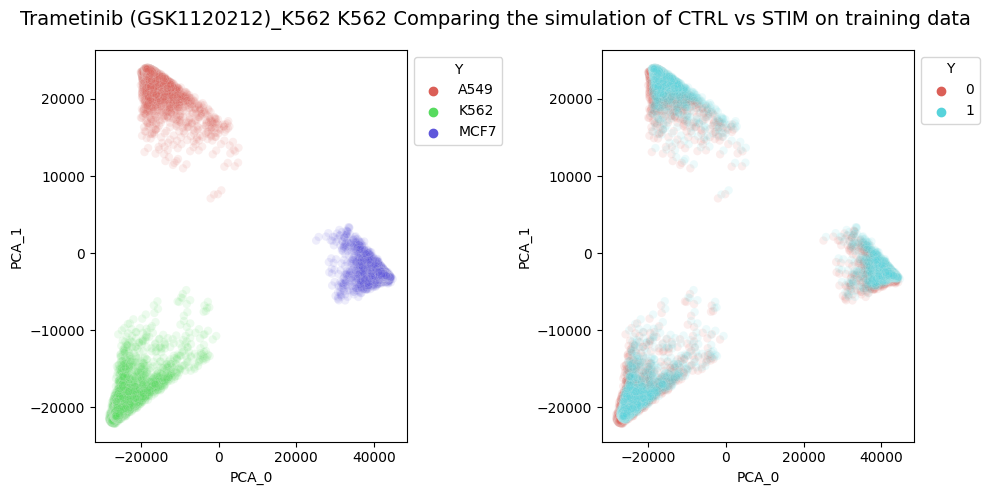

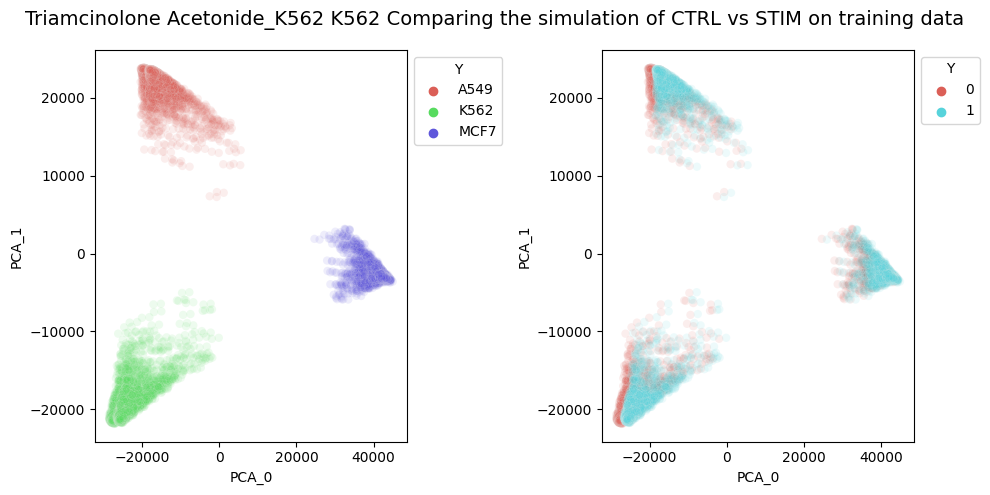

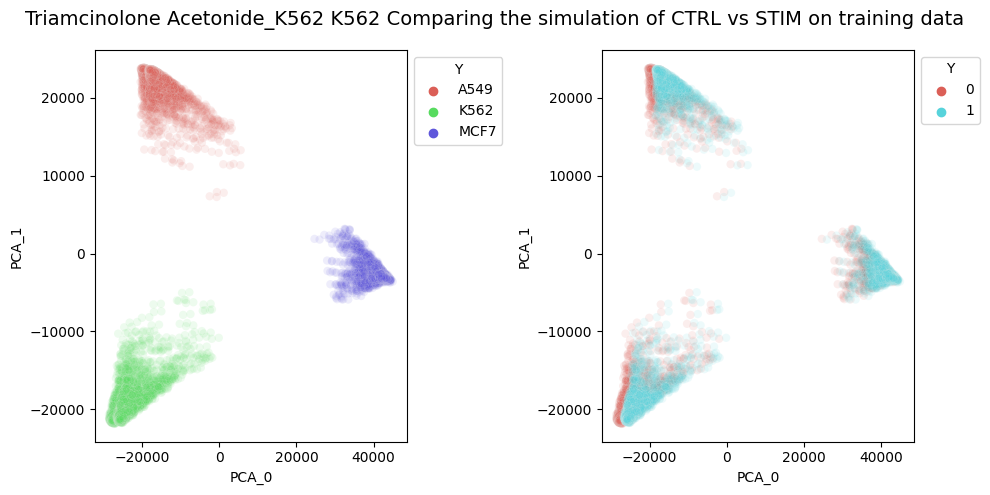

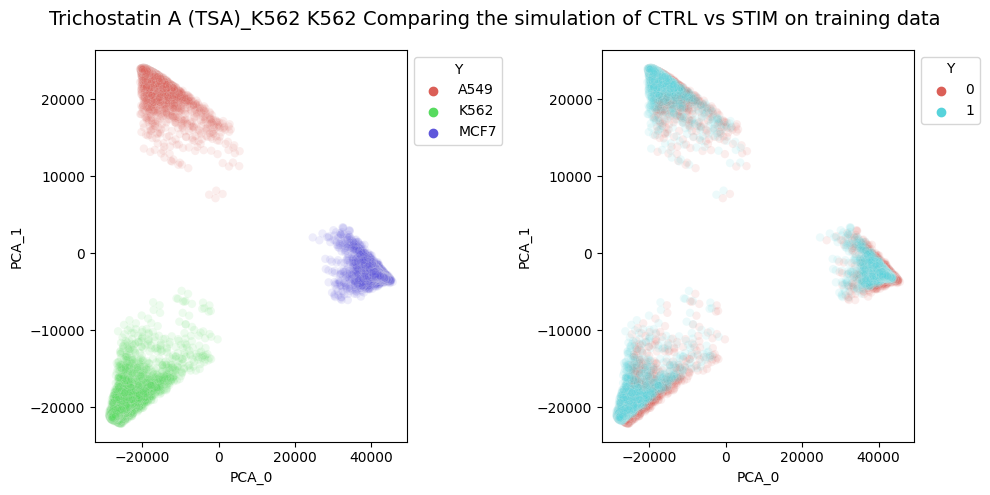

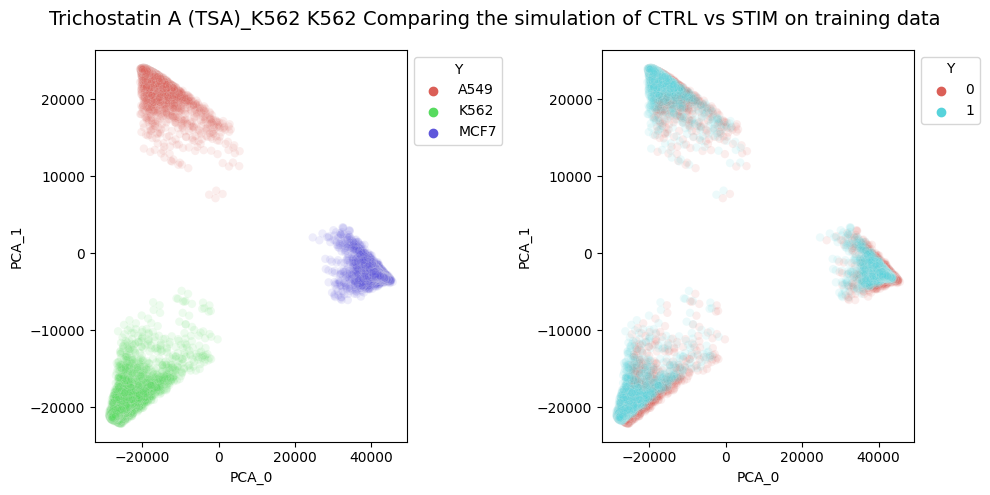

In [85]:
# per cell type
res1_df = get_nonperturbed_log2fc(curr_treatment,
                            meta_df, X_full, scaler)


In [86]:
res1_df

log2FC source Y_max                           perturbation
0    2699   proj  A549  Fedratinib (SAR302503, TG101348)_K562
1       0   real  A549  Fedratinib (SAR302503, TG101348)_K562
0    3277   proj  MCF7  Fedratinib (SAR302503, TG101348)_K562
1       0   real  MCF7  Fedratinib (SAR302503, TG101348)_K562
0    2205   proj  A549             Tanespimycin (17-AAG)_K562
1       0   real  A549             Tanespimycin (17-AAG)_K562
0    1953   proj  MCF7             Tanespimycin (17-AAG)_K562
1       0   real  MCF7             Tanespimycin (17-AAG)_K562
0    1868   proj  A549           Trametinib (GSK1120212)_K562
1       0   real  A549           Trametinib (GSK1120212)_K562
0     949   proj  MCF7           Trametinib (GSK1120212)_K562
1       0   real  MCF7           Trametinib (GSK1120212)_K562
0    1376   proj  A549           Triamcinolone Acetonide_K562
1       1   real  A549           Triamcinolone Acetonide_K562
0     242   proj  MCF7           Triamcinolone Acetonide_K562
1       0   real  MCF7           Triamcinolone Acetonide_K562
0    4475   proj  A549              Trichostatin A (TSA)_K562
1       0   real  A549              Trichostatin A (TSA)_K562
0    2026   proj  MCF7              Trichostatin A (TSA)_K562
1       0   real  MCF7              Trichostatin A (TSA)_K562

In [87]:
log2fc_res_file = os.path.join(res_data_path, f"{res_id}_PCA_log2fc_null.csv")
res1_df.to_csv(log2fc_res_file, index=False)

In [88]:
from matplotlib_venn import venn3
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve
from random import sample
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score

sns.set_palette("Set2")

# get PR curve

def plot_PR_ROC(proj_ctrl, proj_stim, real_ctrl, real_stim, curr_cell_type, axs, union_genes, num_top=100):

    # this is for the "projected" expression
    # take the median for nomalization
    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)


    real_stim = np.median(rankdata(real_stim, axis=1), axis=0)
    real_ctrl = np.median(rankdata(real_ctrl, axis=1), axis=0)
    real_log2FC = abs(real_stim-real_ctrl)


    # make dataframe of true/false positives
    proj_log2FC_df = pd.DataFrame({"proj_log2FC":proj_log2FC,
                                    "real_log2FC":real_log2FC}, index=union_genes)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    # make a random one
    temp_samp = sample(proj_log2FC_df["proj_log2FC"].tolist(), len(proj_log2FC_df["proj_log2FC"].tolist()))
    temp_samp = [int(a) for a in temp_samp]
    proj_log2FC_df["random"] = temp_samp


    proj_log2FC_df["top_DE"] = 0
    proj_log2FC_df = proj_log2FC_df.sort_values(["real_log2FC"], ascending=False)
    proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1




    # now do the single-cell cell type specific DE
    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df["proj_log2FC"], name="PCA", ax=axs[0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df["proj_log2FC"], name="PCA", ax=axs[1])


    roc_display = RocCurveDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df.random, name="random",ax= axs[0])
    pr_display = PrecisionRecallDisplay.from_predictions(proj_log2FC_df.top_DE, proj_log2FC_df.random, name="random", ax=axs[1])

    sc_avg_pr_BuDDI = average_precision_score(proj_log2FC_df.top_DE, proj_log2FC_df["proj_log2FC"])
    sc_avg_pr_random = average_precision_score(proj_log2FC_df.top_DE, proj_log2FC_df.random)

    res_df = pd.DataFrame([sc_avg_pr_BuDDI, sc_avg_pr_random])
    res_df.columns = ["scores"]
    res_df["metric"] = ["avg_pr"]*2
    res_df["cell_type"] = [curr_cell_type]*2
    res_df["ref_set"] = ["sc"]*2
    res_df["method"] = ["BuDDI", "random"]
    res_df["num_top"] = [num_top]*2

    return axs, proj_log2FC_df, res_df


In [89]:
def get_PRAUC(curr_cell_type_perturbed,
                meta_df, X_full, union_genes, scaler, num_top):
    
    curr_samp = "samp1"

    ct_perturbed_idx = np.where(meta_df["cell_type_perturbed"] == curr_cell_type_perturbed)[0]

    all_perts = meta_df.iloc[ct_perturbed_idx].perturbation.unique()
    all_perts = np.setdiff1d(all_perts, "control")


    curr_cell_type = curr_cell_type_perturbed

    all_res_df = None

    for curr_drug in all_perts:

        print(f"{curr_drug} {curr_cell_type_perturbed}")

        drug_idx = np.where((meta_df["perturbation"] == curr_drug) | (meta_df["perturbation"] == "control"))[0]
        curr_idx = np.intersect1d(drug_idx, ct_perturbed_idx)


        sc_proj_meta_df, decoded_0_0, decoded_0_1 = calc_PCA_perturbation(X_full, meta_df, scaler, 
                                                                            fit, curr_samp, 
                                                                            curr_cell_type_perturbed, 
                                                                            curr_drug)
        decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
        decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)



        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full[curr_idx], decoded_0_0, 
                                                                                            decoded_0_1, scaler, curr_samp, 
                                                                                            "cell_type_specific", 
                                                                                            meta_df.iloc[curr_idx], sc_proj_meta_df,
                                                                                            curr_cell_type_perturbed)

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs, proj_log2FC_df, res_df = plot_PR_ROC(proj_ctrl, proj_stim, real_ctrl, real_stim, curr_cell_type, axs, union_genes, num_top)
        res_df["perturbation"] = curr_drug
        all_res_df = pd.concat([all_res_df, res_df])

    return all_res_df


Fedratinib (SAR302503, TG101348)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Tanespimycin (17-AAG)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trametinib (GSK1120212)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Triamcinolone Acetonide_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trichostatin A (TSA)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


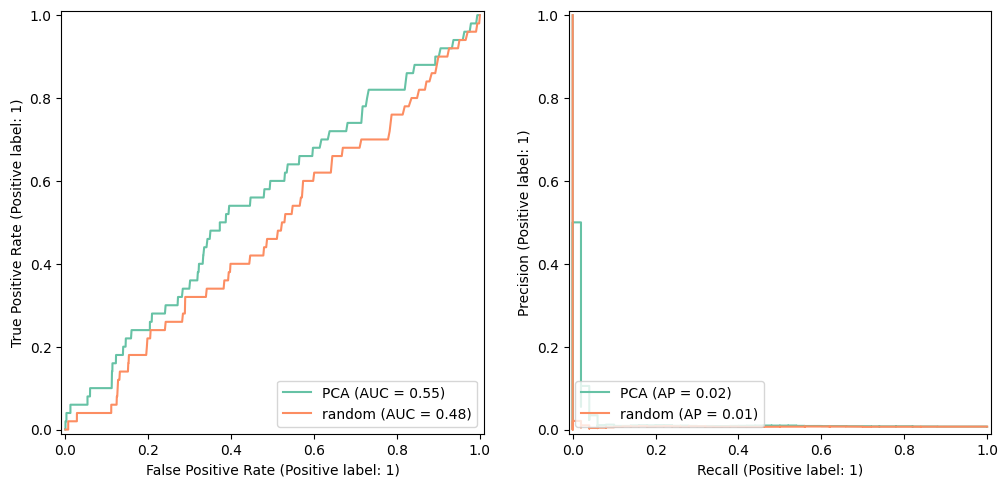

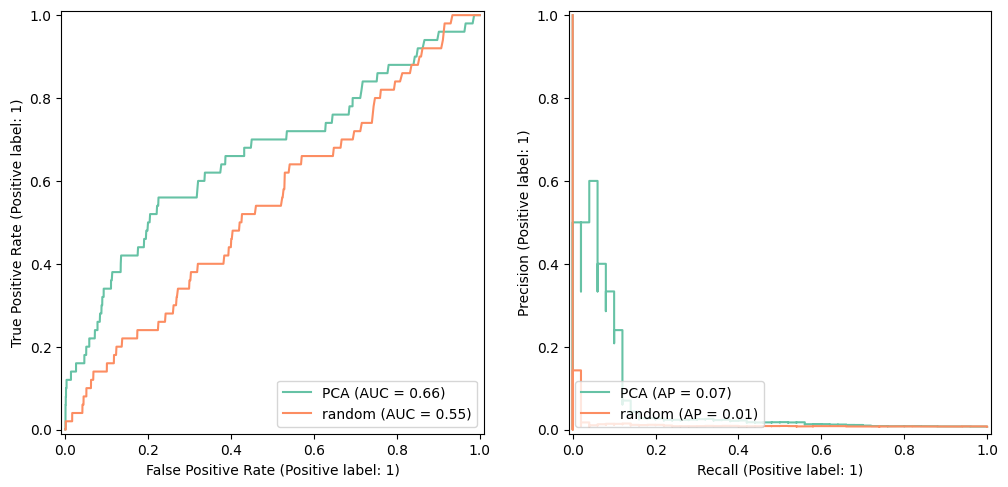

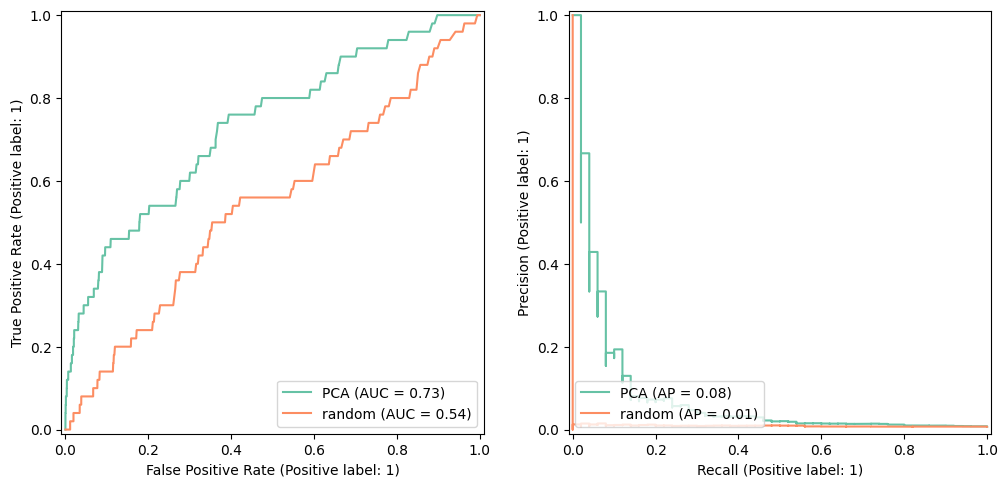

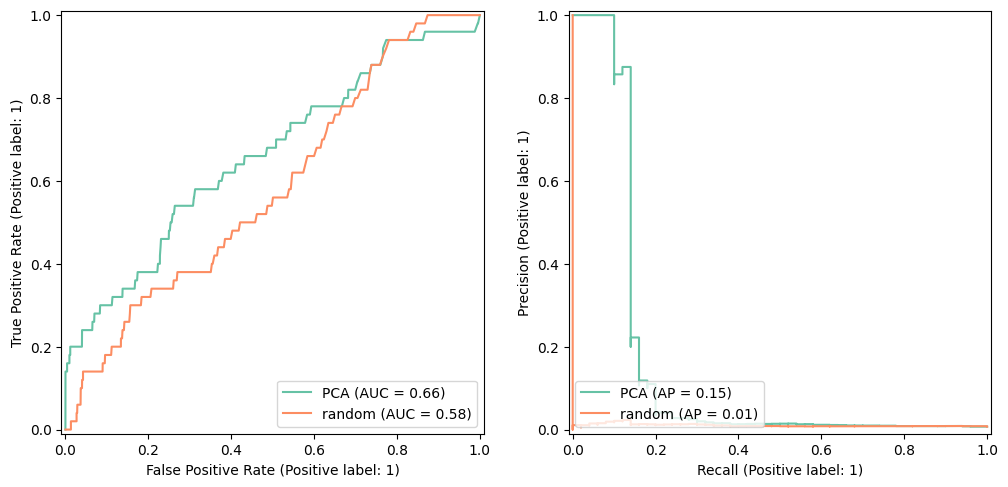

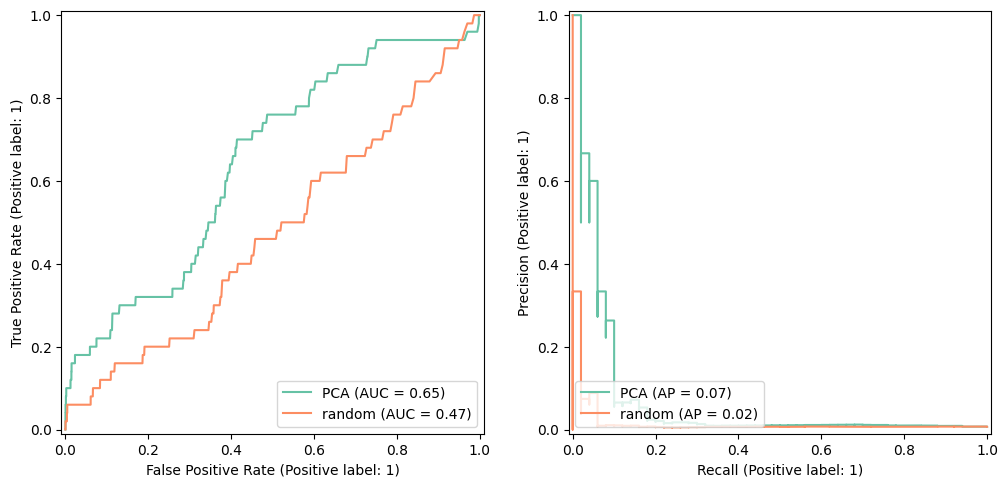

In [90]:
num_top = 50
pr_df1 = get_PRAUC(curr_treatment,
                    meta_df, X_full, union_genes, scaler, num_top)

prauc_res_file = os.path.join(res_data_path, f"{res_id}_{num_top}_PCA_prauc.csv")
pr_df1.to_csv(prauc_res_file, index=False)

Fedratinib (SAR302503, TG101348)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Tanespimycin (17-AAG)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trametinib (GSK1120212)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Triamcinolone Acetonide_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


Trichostatin A (TSA)_K562 K562


/tmp/ipykernel_1254855/4185180289.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj_log2FC_df.top_DE.iloc[range(0,num_top)] = 1


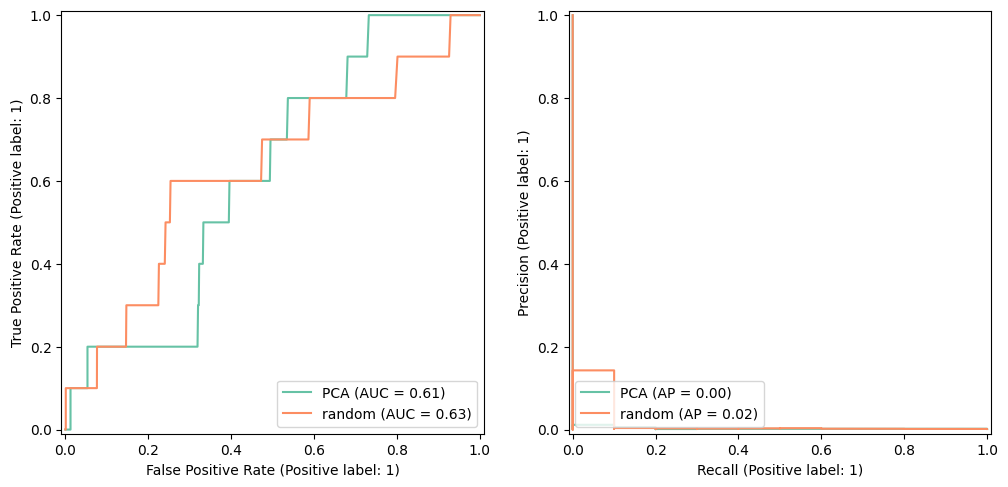

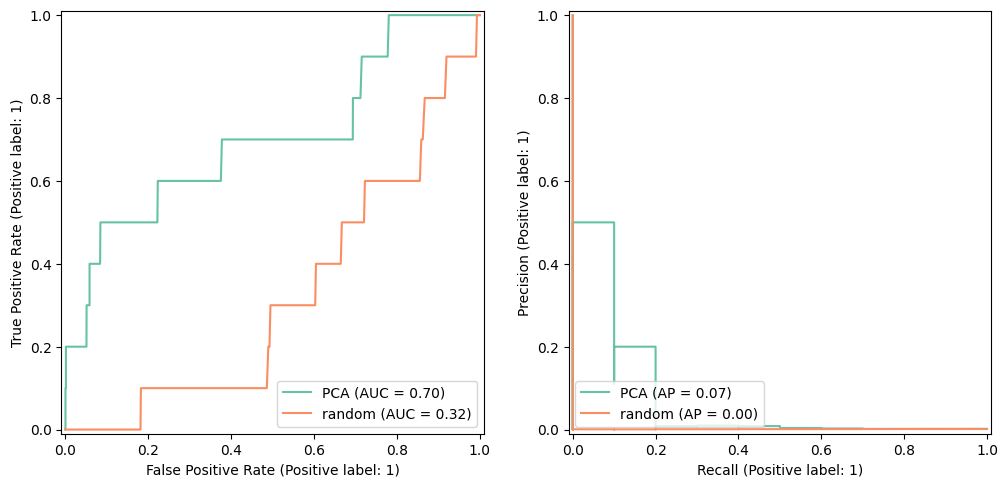

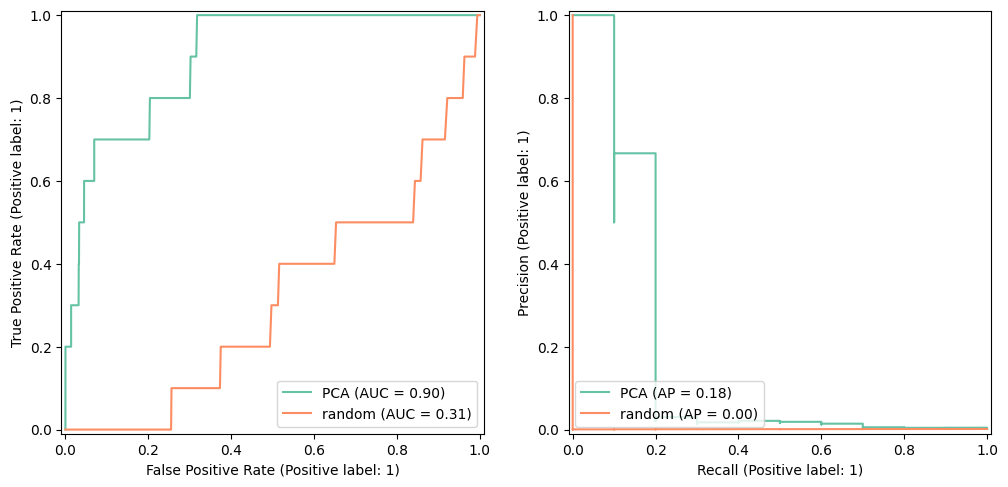

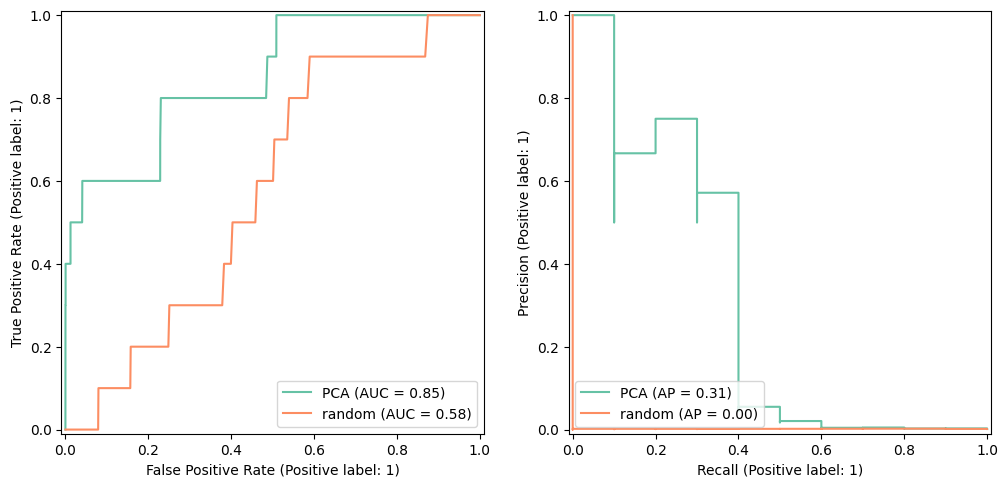

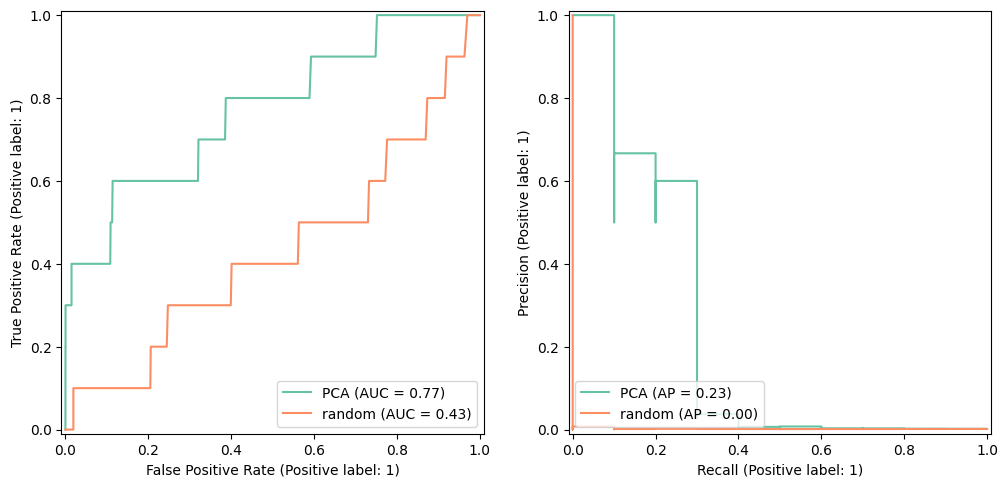

In [91]:
num_top = 10
pr_df1 = get_PRAUC(curr_treatment,
                    meta_df, X_full, union_genes, scaler, num_top)

prauc_res_file = os.path.join(res_data_path, f"{res_id}_{num_top}_PCA_prauc.csv")
pr_df1.to_csv(prauc_res_file, index=False)

In [92]:
pr_df1

scores  metric cell_type ref_set  method  num_top  \
0  0.003225  avg_pr      K562      sc   BuDDI       10   
1  0.016554  avg_pr      K562      sc  random       10   
0  0.073823  avg_pr      K562      sc   BuDDI       10   
1  0.001076  avg_pr      K562      sc  random       10   
0  0.178273  avg_pr      K562      sc   BuDDI       10   
1  0.001058  avg_pr      K562      sc  random       10   
0  0.307840  avg_pr      K562      sc   BuDDI       10   
1  0.001834  avg_pr      K562      sc  random       10   
0  0.232819  avg_pr      K562      sc   BuDDI       10   
1  0.001986  avg_pr      K562      sc  random       10   

                            perturbation  
0  Fedratinib (SAR302503, TG101348)_K562  
1  Fedratinib (SAR302503, TG101348)_K562  
0             Tanespimycin (17-AAG)_K562  
1             Tanespimycin (17-AAG)_K562  
0           Trametinib (GSK1120212)_K562  
1           Trametinib (GSK1120212)_K562  
0           Triamcinolone Acetonide_K562  
1           Triamcinolone Acetonide_K562  
0              Trichostatin A (TSA)_K562  
1              Trichostatin A (TSA)_K562